In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

c:\Users\Sandra\Documents\Visual_Studio_Code\Github\AI-Sandra-Andersson-OPA23\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
movies = 'data/ml-latest/movies.csv'
ratings = 'data/ml-latest/ratings.csv'
tags = 'data/ml-latest/tags.csv'

df_movies = pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId':'int32', 'title':'str'})
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId': 'int32', 'rating':'float32'})
df_tags = pd.read_csv(tags, usecols=['userId', 'movieId', 'tag'], dtype={'userId':'int32', 'movieId': 'int32', 'tag':'str'})

### a) EDA

In [3]:
df_tags.head(10)

,userId,movieId,tag
0,10,260,good vs evil
1,10,260,Harrison Ford
2,10,260,sci-fi
3,14,1221,Al Pacino
4,14,1221,mafia
5,14,58559,Atmospheric
6,14,58559,Batman
7,14,58559,comic book
8,14,58559,dark
9,14,58559,Heath Ledger


In [4]:
df_movies.info()
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [5]:
df_movies.shape

(86537, 2)

In [6]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [7]:
df_ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
5,1,381,3.5
6,1,596,4.0
7,1,1036,5.0
8,1,1049,3.0
9,1,1066,4.0


In [8]:
num_movies = df_movies.shape
num_ratings = df_ratings.shape
print(f'\nTotal number of movies and columns: {num_movies}')
print(f'Total number of ratings and columns: {num_ratings}')


Total number of movies and columns: (86537, 2)
Total number of ratings and columns: (33832162, 3)


### b) De 10 filmer med flest ratings

In [9]:
# Beräknar antalet betyg per film
ratings_count = df_ratings['movieId'].value_counts().reset_index()
ratings_count.columns = ['movieId', 'num_of_ratings']

# Sorterar filmerna efter antalet betyg
sorted_movies = ratings_count.sort_values(by='num_of_ratings', ascending=False)

# 10 filmerna med flest betyg
top_10_movies = sorted_movies.head(10)

# Slår ihop top_10_movies med df_movies för att få titlarna
top_10_movie_title = pd.merge(top_10_movies, df_movies, on='movieId')

print('Top 10 Movies with Most Ratings')
print(top_10_movie_title[['movieId', 'title', 'num_of_ratings']].to_string(index=False))

Top 10 Movies with Most Ratings
 movieId                                                 title  num_of_ratings
     318                      Shawshank Redemption, The (1994)          122296
     356                                   Forrest Gump (1994)          113581
     296                                   Pulp Fiction (1994)          108756
    2571                                    Matrix, The (1999)          107056
     593                      Silence of the Lambs, The (1991)          101802
     260             Star Wars: Episode IV - A New Hope (1977)           97202
    2959                                     Fight Club (1999)           86207
     527                               Schindler's List (1993)           84232
     480                                  Jurassic Park (1993)           83026
    1196 Star Wars: Episode V - The Empire Strikes Back (1980)           80200


### c) Genomsnittliga ratingen för de 10 filmerna med flest ratings

In [10]:
# 10 filmerna med flest betyg
top_10_movies = df_ratings['movieId'].value_counts().head(10).index

# Filtrerar betygen för de 10 filmerna med flest betyg
ratings_top_10 = df_ratings[df_ratings['movieId'].isin(top_10_movies)]

# Beräknar genomsnittligt betyg för varje film
average_ratings_top_10 = ratings_top_10.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')

# Slår ihop top_10_movies med df_movies för att få fram titlarna
top_10_movie_title = pd.merge(average_ratings_top_10, df_movies, on='movieId')

# Sorterar top_10_movie_title efter avg_rating i nedåtgånde ordning
top_10_movie_title_sorted = top_10_movie_title.sort_values(by='avg_rating', ascending=False)

print('Average Ratings for Top 10 Movies')
print(top_10_movie_title_sorted[['movieId', 'title', 'avg_rating']].to_string(index=False))

Average Ratings for Top 10 Movies
 movieId                                                 title  avg_rating
     318                      Shawshank Redemption, The (1994)    4.416792
     527                               Schindler's List (1993)    4.242337
    2959                                     Fight Club (1999)    4.236019
     296                                   Pulp Fiction (1994)    4.191778
    2571                                    Matrix, The (1999)    4.160631
     593                      Silence of the Lambs, The (1991)    4.150287
    1196 Star Wars: Episode V - The Empire Strikes Back (1980)    4.118030
     260             Star Wars: Episode IV - A New Hope (1977)    4.092401
     356                                   Forrest Gump (1994)    4.068189
     480                                  Jurassic Park (1993)    3.689013


### d) Plot över årtal och antalet filmer

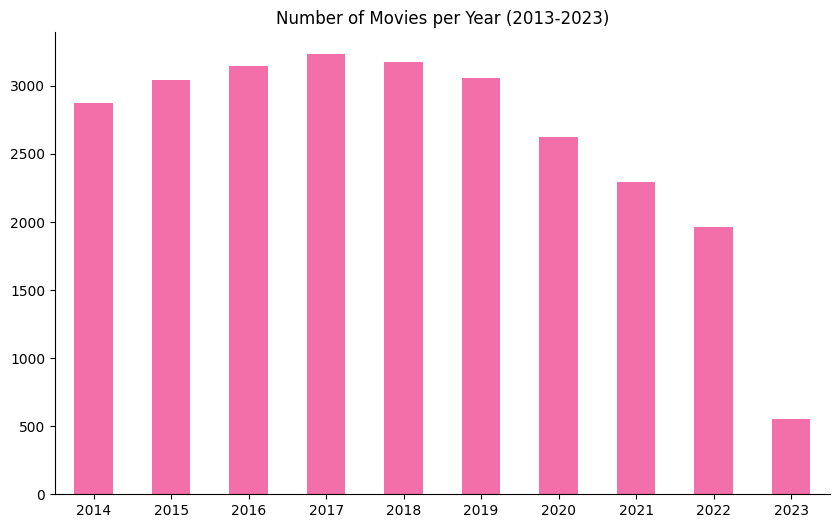

In [11]:
# Extraherar år från titeln: (r'\((\d{4})\)') tar 4 siffror inom parentes, i detta fall år
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')

# Konverterar året till numeriskt format
df_movies['year'] = df_movies['year'].apply(lambda x: pd.to_numeric(x, errors='coerce')).astype('Int32')

# Filtrerar ut filmer mellan 2014 och 2023
df_movies_filtered = df_movies[(df_movies['year'] >= 2014) & (df_movies['year'] <= 2023)]

# Grupperar och beräknar antalet filmer per år
movies_per_year_filtered = df_movies_filtered.groupby('year').size()

# Sorterar resultatet i fallande ordning och tar de sista 10 åren
movies_per_year_filtered_sorted = movies_per_year_filtered.sort_index(ascending=True).head(11)

fig, ax = plt.subplots(figsize=(10, 6))
movies_per_year_filtered_sorted.plot(kind='bar', color='#F26FA9', ax=ax)
ax.set_title('Number of Movies per Year (2013-2023)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


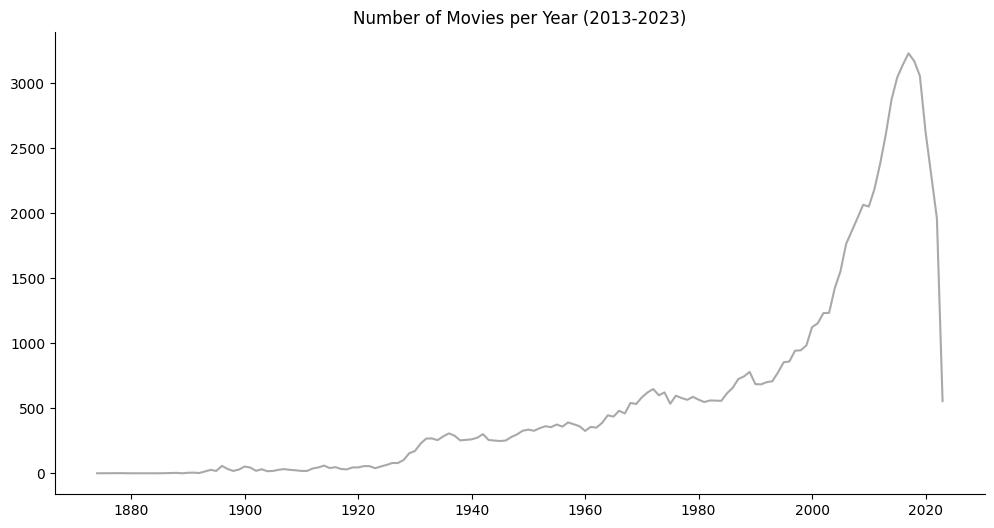

In [12]:
# Extraherar år från titeln: (r'\((\d{4})\)') tar 4 siffror inom parentes, i detta fall år
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')

# Konverterar året till numeriskt format
df_movies['year'] = df_movies['year'].apply(lambda x: pd.to_numeric(x, errors='coerce')).astype('Int32')

# Filtrerar ut filmer mellan 2014 och 2023
df_movies_filtered = df_movies[(df_movies['year'] >= 1874)]

# Grupperar och beräknar antalet filmer per år
movies_per_year_filtered = df_movies_filtered.groupby('year').size()

movies_per_year_filtered_sorted = movies_per_year_filtered.sort_index(ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
movies_per_year_filtered_sorted.plot(kind='line', color='darkgray', ax=ax)
ax.set_title('Number of Movies per Year (2013-2023)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

### e) Plot över antalet ratings mot movieId

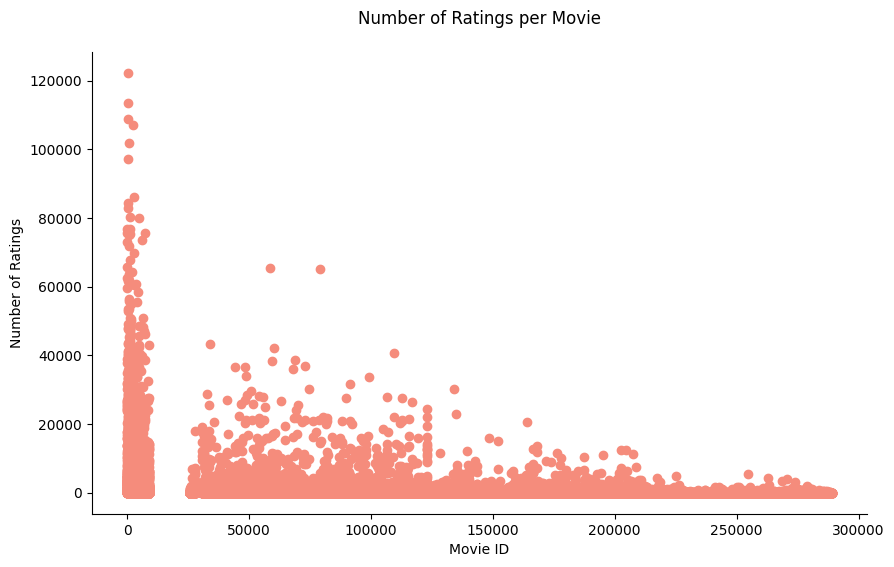

In [13]:
# Antalet betyg per film
ratings_per_movie = df_ratings.groupby('movieId').size()

fig, ax = plt.subplots(figsize=(10, 6))

# Plottar antalet betyg mot movieId
ax.plot(ratings_per_movie.index, ratings_per_movie.values, marker='o', linestyle='', color='#F58C7C')
ax.set_title('Number of Ratings per Movie', pad=20)
ax.set_xlabel('Movie ID')
ax.set_ylabel('Number of Ratings')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

### f) Genomsnittliga ratings för de top 10 filmerna med flest ratings

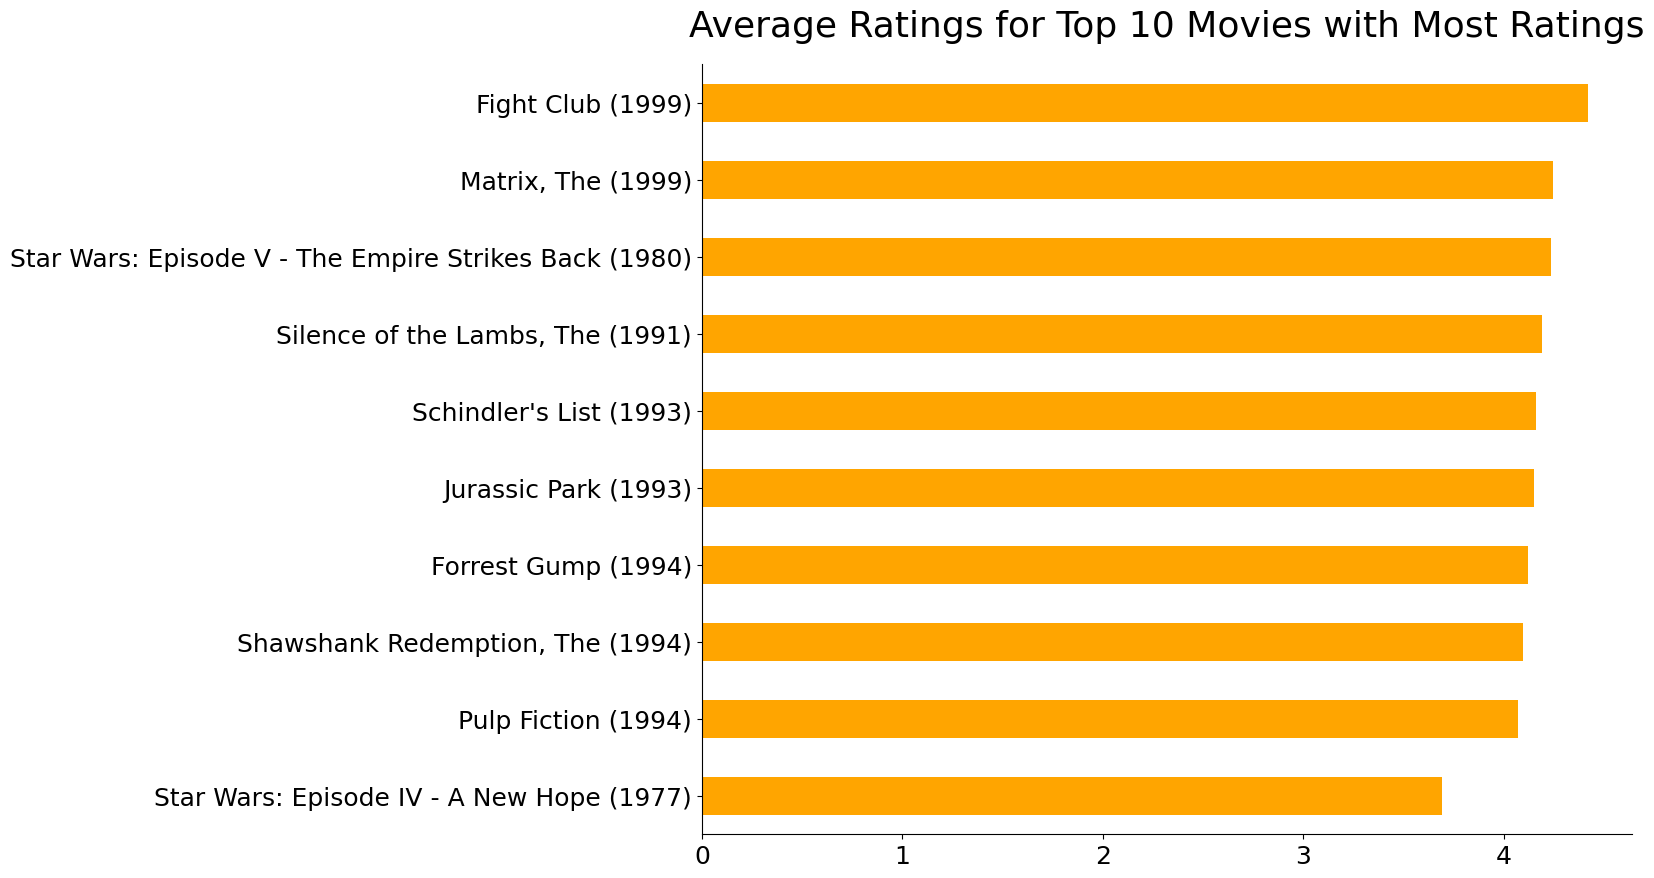

In [14]:
# 10 filmer med flest betyg
top_10_movies = df_ratings['movieId'].value_counts().head(10).index

# Filtrerar betyg för de 10 filmer med flest betyg
ratings_top_10 = df_ratings[df_ratings['movieId'].isin(top_10_movies)]

# Beräknar genomsnittligt betyg för varje film
average_ratings_top_10 = ratings_top_10.groupby('movieId')['rating'].mean()

# Hämtar titlar för de 10 filmer med flest betyg
movie_titles = df_movies[df_movies['movieId'].isin(top_10_movies)].set_index('movieId')['title']

# Sorterar betygen i stigande ordning
average_ratings_top_10_sorted = average_ratings_top_10.sort_values(ascending=True)

# Använder filmernas titlar som index för average_ratings_top_10_sorted
average_ratings_top_10_sorted.index = movie_titles

# Plottar med liggande staplar istället för stående
fig, ax = plt.subplots(figsize=(12, 10))
average_ratings_top_10_sorted.plot(kind='barh', color='orange')
ax.set_title('Average Ratings for Top 10 Movies with Most Ratings', pad=20, font=dict(size=26), loc='center')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


In [15]:
user_freq = df_ratings[['userId', 'movieId']].groupby(
    'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head(20))

    userId  n_ratings
0        1         62
1        2         91
2        3         30
3        4         30
4        5         43
5        6         48
6        7        165
7        8         15
8        9        169
9       10        162
10      11         37
11      12         55
12      13         45
13      14        144
14      15         44
15      16          7
16      17         85
17      18          1
18      19          5
19      20          4


In [16]:
n_ratings = len(df_ratings)
n_movies = len(df_ratings['movieId'].unique())
n_users = len(df_ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 33832162
Number of unique movieId's: 83239
Number of unique users: 330975
Average ratings per user: 102.22
Average ratings per movie: 406.45


## 1.2

In [17]:

# Fyller NaN-värden med 'ND' i kolumnen 'tag'
df_tags_filled = df_tags.fillna({'tag': 'ND'})

# Skapar en ny DataFrame för betygen för filmer som tillhör den specifika genren
df_filtered_genre = df_ratings[df_ratings['movieId'].isin(df_movies['movieId'])]

# Filtrerar ut användare och filmer baserat på antal betyg som getts och mottagits
min_user_ratings = 40
min_movie_ratings = 400

# Antalet betyg per användare och film
user_counts = df_ratings['userId'].value_counts()
movie_counts = df_ratings['movieId'].value_counts()

# Filtrerar användare och filmer baserat på antal betyg
filtered_users = user_counts[user_counts >= min_user_ratings].index
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index

# Filtrerar DataFramen för att bara behålla betyg från dessa användare och filmer
df_filtered = df_ratings[(df_ratings['userId'].isin(filtered_users)) & 
                         (df_ratings['movieId'].isin(filtered_movies))]

# Betyg baserat på användare och filmer
min_rating = 3
df_filtered_rating = df_filtered[(df_filtered['rating'] >= min_rating)]

# Skapar en gles matris från den filtrerade DataFramen
sparse_matrix_csr = csr_matrix((df_filtered['rating'], (df_filtered['movieId'], df_filtered['userId'])))

# Resultatet blir en gles matris där varje rad representerar en film och varje kolumn representerar en användare,
# och varje cell innehåller betyget som användaren har gett filmen

In [18]:
# Skapar en ny DataFrame för betyg för filmer som tillhör en specifik genre
df_filtered_rating = df_ratings[df_ratings['movieId'].isin(df_movies['movieId'])]
df_filtered_genre = df_tags[df_tags['tag'].isin(df_movies['movieId'])]

In [19]:
df_filtered_genre.info()
df_filtered_genre.head(10)
print('-----------------------------------')
df_filtered_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   userId   0 non-null      int32 
 1   movieId  0 non-null      int32 
 2   tag      0 non-null      object
dtypes: int32(2), object(1)
memory usage: 0.0+ bytes
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [20]:
# Skapar en CSR-matris för att representera användare- och film-betyg
def sparse_matrix(sparse_matrix_csr):
    # Räknar antalet unika användare och filmer (N och M)
    # N = längden på listan av unika användar-ID i DataFrame df['userId']
    # M = längden på listan av unika film-ID i DataFrame df['movieId']
    N = len(sparse_matrix_csr['userId'].unique())
    M = len(sparse_matrix_csr['movieId'].unique())

    # Mappning från ID till index (user_mapper och movie_mapper)

    # list(range(N/M)) skapar en lista med index från 0 till N-1.
    # dict(zip(...)) skapar en dictionary där varje unikt ID matchas med motsvarande index.

    # Mappar Ids till indices
    user_map = dict(zip(np.unique(sparse_matrix_csr["userId"]), list(range(N)))) #returnerar en lista med unika användar-ID i DataFrame df["userId"]
    movie_map = dict(zip(np.unique(sparse_matrix_csr["movieId"]), list(range(M)))) #returnerar en lista med unika film-ID i DataFrame df["movieId"]


    # Mappar från index till ID (user_inv_mapper och movie_inv_mapper)

    # Samma som ovan,fast med index som nycklar och ID som värden.
    # Mappar indices till Ids
    user_invert_map = dict(zip(list(range(N)), np.unique(sparse_matrix_csr["userId"])))
    movie_invert_map = dict(zip(list(range(M)), np.unique(sparse_matrix_csr["movieId"])))

    # Skapar index för användare och filmer i DataFrame df(user_index och movie_index)

    # user_index är en lista med användarindex i DataFrame df baserat på user_mapper
    # movie_index är en lista med filmindex i DataFrame df baserat på movie_mapper
    user_index = [user_map[i] for i in sparse_matrix_csr['userId']]
    movie_index = [movie_map[i] for i in sparse_matrix_csr['movieId']]

    # Skapar en CSR-matris(X) för användare- och film-betyg

    # en lista med betyg
    # row_indices är en lista med radindex för betyg
    # col_indices är en lista med kolumnindex för betygen
    # shape=(M, N) anger dimensionerna på matrisen där M är antalet rader (filmer) och N är antalet kolumner (användare)

    X = csr_matrix((sparse_matrix_csr["rating"], (movie_index, user_index)), shape=(M, N)) # skapar en komprimerad sparad rad (CSR) matris från betyg (data) med tillhörande rad- och kolumnindex

    # Returnerar matrisen X som representerar användare- och film-betyg, samt de fyra mappningarna: user_mapper, movie_mapper, user_inv_mapper, och movie_inv_mapper, som kan användas för att översätta mellan ID och index.

    return X, user_map, movie_map, user_invert_map, movie_invert_map


X, user_map, movie_map, user_invert_map, movie_invert_map = sparse_matrix(df_filtered_rating)


## 1.3

In [21]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=2)

In [22]:
model_knn.fit(X)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=2)

In [23]:
# Hitta liknande filmer med hjälp av KNN
def find_similar_movies(movie_title, X, k=5, metric='cosine', show_distance=False):
    neighbour_ids = []

    # söker efter den närmaste matchande filmtiteln för den användarvalda titeln med hjälp av FuzzyWuzzy
    movie_match = process.extractOne(movie_title, df_movies["title"]) 
    # Om en matchning hittas, returneras en tuple med matchande titel, matchpoäng och index för den matchande titeln
    
    # Om en matchning hittas, hämtas den matchande titeln, 'matchpoängen' och index från tupeln
    # Filmens id hämtas från DataFrame df_movies med hjälp av index, och sen lagras filmens id i variabeln selected_movie_id

    if movie_match is not None:
        matched_title, score, idx = movie_match
        print(f"Closest match: {matched_title} (Score: {score})")
        selected_movie_id = df_movies.loc[idx, 'movieId']
        print(f"Selected movieId: {selected_movie_id}")

        # Beräknar index för den matchande filmen i CSR-matrisen (movie_ind)
        # används för att översätta filmens id till dess motsvarande index i CSR-matrisen
        movie_ind = movie_map[selected_movie_id]
        movie_vec = X[movie_ind]

    #
    # Söker efter alla filmer som innehåller den angivna titeln
    matching_movies = df_movies[df_movies['title'].str.contains(movie_title, case=False)]

    if not matching_movies.empty:
        print(f"Found {len(matching_movies)} matching movies. Here are top 5:")
        for idx, movie in matching_movies.head(5).iterrows():
            
            print(f"{movie['title']}")

        # Väljer den första matchande filmen
        selected_movie_id = matching_movies.iloc[0]['movieId']
    
        movie_ind = movie_map[selected_movie_id]
        movie_vec = X[movie_ind]
        #
        
        # KNN används för att hitta liknande filmer

        # Instans av NearestNeighbors skapas med antalet grannar 'k' och metric
        # CSR-matrisen X anpassas till fit()-metoden för att träna modellen
        k += 1
        kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
        kNN.fit(X)
        
        movie_vec = movie_vec.reshape(1, -1)
        
        # .kneighbours används för att hitta de närmaste k grannarna till den matchande filmen
        # Den matchande filmens vektor (movie_vec) hämtas från matrisen
        # Om show_distance (i konstruktorn) är satt till True, returnerasavståndet mellan den matchande filmen och dess grannar
        neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)

    #     Översätt index för grannarna till film-id (neighbour_ids)

        # Indexen för grannarna returneras från kneighbors-funktionen
        # Dessa indexen översätts sen till film-id med hjälp av mappningen movie_invert_map
        # De 'översatta' film-iderna lagras i listan neighbour_ids.

        for i in range(0, k):
            n = neighbour.item(i)
            neighbour_ids.append(movie_invert_map[n])
        neighbour_ids.pop(0)
    else:
        print("Movie not found.")

    # Om matchning hittas, returneras listan neighbour_ids som innehåller id för de liknande filmerna
    # Om ingen matchning hittades, returneras en tom lista
    return neighbour_ids

# Användaren får mata in en filmtitel
selected_movie_title = 'Toy story' #input("Vilken film vill du söka på? ")

# Hittar liknande filmer baserat på användarens input
similar_movie_ids = find_similar_movies(selected_movie_title, X)
print('----------------------------------------------------')
print(f"\nSince you watched {selected_movie_title}, you might like:")
movie_titles = df_movies.set_index('movieId')['title'].to_frame()

# Använder DataFrame för att kolla om movie_id finns och hämta titel baserat på index
for movie_id in similar_movie_ids:
    if movie_id in movie_titles.index:
        print(f"{movie_titles.loc[movie_id, 'title']}")
    else:
        print(f"Title not found for movie_id: {movie_id}")

Closest match: Toy Story (1995) (Score: 90)
Selected movieId: 1
Found 9 matching movies. Here are top 5:
Toy Story (1995)
Toy Story 2 (1999)
Toy Story 3 (2010)
Toy Story of Terror (2013)
Toy Story Toons: Hawaiian Vacation (2011)
----------------------------------------------------

Since you watched Toy story, you might like:
Toy Story 2 (1999)
Star Wars: Episode IV - A New Hope (1977)
Independence Day (a.k.a. ID4) (1996)
Back to the Future (1985)
Jurassic Park (1993)


a) Beskriv med ord hur ditt system fungerar.
- Detta rekommendationssystemet använder en k-nearest neighbors algoritm för att hitta filmer som liknar den valda/sökta filmen. Först använder vi FuzzyWuzzy för att hitta den närmsta matchande titeln baserat på "matchningspoäng". Hittas en matchning så hämtas id från databasen som sen används för att hitta motsvarande vektor i CSR-matrisen. Finns det fler med samma titel väljs den första. Sedan används KNN för att hitta de närmaste "grannarna" till den matchande filmen genom namnmatchning och vilka som liknar mest. Där hämtas index och dessa översätts till filmens id med hjälp av en omvänd kartläggning, och de översatta film-id:na lagras i en lista. Det är denna lista med id och titlar som skrivs ut och rekomenderas. Jag har även valt att behålla delen där de rekomenderade filmerna baseras på rating då jag tycker det finns en viss relevans även i detta. Även id för de liknande filmerna visas.

b) Leta online och läs vidare om rekommenderarsystem och beskriv kort hur dem fungerar. Glöm inte
källhänvisa

Rekommendationssystem är en typ av informationsfiltreringssystem som används för att kunna förutspå vad en användare kan vara intresserad av och föreslår likadant innehåll/produkter. De fungerar vanligtvis genom att analysera en användares beteende, preferenser och användarmönster för att sedan kunna ta fram relevanta rekommendationer utifrån detta.

- Det finns tre olika sätt att bygga rekommendationssystem:
    - "Collaborative filtering" samlar och analyserar data om användarbeteende för att förutspå vad en person kommer att gilla baserat på deras likhet med andra användare. Det behöver inte förstå innehållet utan väljer rekommendationer baserat på användarinformationen.

    - "Content-based filtering" föreslår objekt baserat på likheten med objekt som användaren redan gillar. Det använder ett profilverktyg för kundpreferenser och objektbeskrivningar för att beräkna likheter. Om någon t.ex. Gillar många skräckfilmer så rekomenderas inte barnfilmer.

    - "Hybrid"modeller kombinerar både samarbets- och innehållsbaserad filtrering för att ge bättre rekommendationer än enbart en metod. Dessa modeller använder både användarpreferenser och objektbeskrivningar för att göra rekommendationer. Netflix är ett exempel på en hybridmodell som tar hänsyn till både användarintressen och innehållsbeskrivningar för att ge rekommendationer.

- https://blog.dataiku.com/recommendation-engines-how-they-work-in-plain-english
- https://www.appier.com/en/blog/what-is-a-recommendation-engine-and-how-does-it-work
- https://medium.com/voice-tech-podcast/a-simple-way-to-explain-the-recommendation-engine-in-ai-d1a609f59d97
- https://amplitude.com/blog/recommendation-engine
- https://towardsdatascience.com/recommendation-systems-explained-a42fc60591ed

## 2

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [25]:
cardio_data = 'data/cardio_train.csv'

df_cardio = pd.read_csv(cardio_data, sep = ";")

In [26]:
df_cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [27]:
df_cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [28]:
df_cardio.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


                   id       age    gender    height    weight     ap_hi  \
id           1.000000  0.003457  0.003502 -0.003038 -0.001830  0.003356   
age          0.003457  1.000000 -0.022811 -0.081515  0.053684  0.020764   
gender       0.003502 -0.022811  1.000000  0.499033  0.155406  0.006005   
height      -0.003038 -0.081515  0.499033  1.000000  0.290968  0.005488   
weight      -0.001830  0.053684  0.155406  0.290968  1.000000  0.030702   
ap_hi        0.003356  0.020764  0.006005  0.005488  0.030702  1.000000   
ap_lo       -0.002529  0.017647  0.015254  0.006150  0.043710  0.016086   
cholesterol  0.006106  0.154424 -0.035821 -0.050226  0.141768  0.023778   
gluc         0.002467  0.098703 -0.020491 -0.018595  0.106857  0.011841   
smoke       -0.003699 -0.047633  0.338135  0.187989  0.067780 -0.000922   
alco         0.001210 -0.029723  0.170966  0.094419  0.067113  0.001408   
active       0.003755 -0.009927  0.005866 -0.006570 -0.016867 -0.000033   
cardio       0.003799  0.

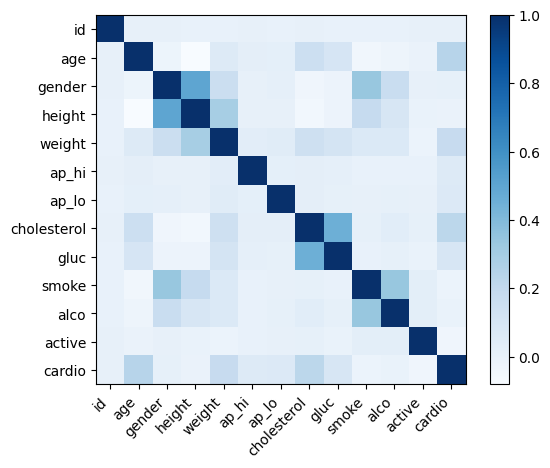

In [29]:
matrix = df_cardio.corr()
print(matrix)

plt.imshow(matrix, cmap='Blues')

plt.colorbar()

variables = []
for i in matrix.columns:
  variables.append(i)

plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

plt.show()

In [30]:
df_cardio.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [31]:
# Skapar en ny funktion som anger åldern i år
df_cardio['ageY'] = df_cardio['age'] / 365
# Tar bort 'id'-kolumnen
df_cardio.pop('id')


0            0
1            1
2            2
3            3
4            4
         ...  
69995    99993
69996    99995
69997    99996
69998    99998
69999    99999
Name: id, Length: 70000, dtype: int64

In [32]:
df_cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ageY
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.391781
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.419178
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.663014
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.282192
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.873973


In [33]:
df_cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
 12  ageY         70000 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


In [34]:
#Tar bort outliers fråm blodtryck som är högre än dessa värden
datafil = ((df_cardio["ap_hi"]>250) | (df_cardio["ap_lo"]>200))
df = df_cardio[~datafil]

#Tar bort outliers fråm blodtryck som är lägre än dessa värden
datafil2 = ((df["ap_hi"] < 0) | (df["ap_lo"] < 0))
df = df[~datafil2]
# Ny längd på datasetet
len(df)

68999

In [35]:
# Grupperar åldrar i spann för att kunna fördela enklare
#29-34 = 0 (Adult Young)
#35-40 = 1 (Adult Old)
#41-50 = 2 (Middle Age Young)
#51-59 = 3 (Middle Age Old)
#60< = 4 (Senior)

df.loc[(df['ageY'] > 0 ) & (df['ageY'] < 35), 'age'] = 0
df.loc[(df['ageY'] >= 35 ) & (df['ageY'] < 41), 'age'] = 1
df.loc[(df['ageY'] >= 41 ) & (df['ageY'] < 51), 'age'] = 2
df.loc[(df['ageY'] >= 51 ) & (df['ageY'] < 60), 'age'] = 3
df.loc[(df['ageY'] >= 60 ), 'age'] = 4


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68999 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68999 non-null  int64  
 1   gender       68999 non-null  int64  
 2   height       68999 non-null  int64  
 3   weight       68999 non-null  float64
 4   ap_hi        68999 non-null  int64  
 5   ap_lo        68999 non-null  int64  
 6   cholesterol  68999 non-null  int64  
 7   gluc         68999 non-null  int64  
 8   smoke        68999 non-null  int64  
 9   alco         68999 non-null  int64  
 10  active       68999 non-null  int64  
 11  cardio       68999 non-null  int64  
 12  ageY         68999 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 7.4 MB


In [37]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ageY
count,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000,68999.000000
mean,2.784345,1.348715,164.359759,74.118574,126.322497,81.333976,1.364382,1.225858,0.087871,0.053595,0.803287,0.494877,53.325454
std,0.799659,0.476567,8.204275,14.328439,17.708323,9.872897,0.678699,0.571812,0.283109,0.225218,0.397516,0.499977,6.762367
min,0.000000,1.000000,55.000000,11.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.583562
25%,2.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.373973
50%,3.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.972603
75%,3.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.419178
max,4.000000,2.000000,250.000000,200.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.967123


                  age    gender    height    weight     ap_hi     ap_lo  \
age          1.000000 -0.017423 -0.073177  0.051838  0.184320  0.141538   
gender      -0.017423  1.000000  0.498012  0.155970  0.058219  0.064712   
height      -0.073177  0.498012  1.000000  0.291528  0.017632  0.035881   
weight       0.051838  0.155970  0.291528  1.000000  0.255150  0.245323   
ap_hi        0.184320  0.058219  0.017632  0.255150  1.000000  0.646268   
ap_lo        0.141538  0.064712  0.035881  0.245323  0.646268  1.000000   
cholesterol  0.143536 -0.036716 -0.050482  0.140679  0.186315  0.155435   
gluc         0.088330 -0.020975 -0.018522  0.106907  0.087976  0.076045   
smoke       -0.041003  0.338668  0.187960  0.066781  0.028087  0.024594   
alco        -0.028609  0.171011  0.094466  0.067933  0.031552  0.042940   
active      -0.009396  0.005517 -0.007297 -0.017979  0.000676 -0.000949   
cardio       0.227606  0.007528 -0.010396  0.179982  0.401371  0.328847   
ageY         0.927535 -0.

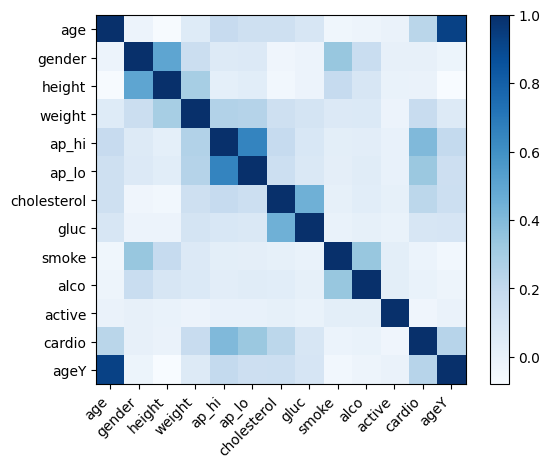

In [38]:
import matplotlib.pyplot as plt
matrix = df.corr()
print(matrix)

# Plottar korrelationsmatris
plt.imshow(matrix, cmap='Blues')

plt.colorbar()

# Tar fram variabel/kolumnnamn 
variables = []
for i in matrix.columns:
  variables.append(i)

plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

plt.show()

In [39]:
positives = sum(df_cardio['cardio'] == 1)

negatives = sum(df_cardio['cardio'] == 0)

print(f'Antal positiva för hjärt-kärlsjukdom: {positives}')
print(f'Antal negativa för hjärt-kärlsjukdom: {negatives}')

Antal positiva för hjärt-kärlsjukdom: 34979
Antal negativa för hjärt-kärlsjukdom: 35021


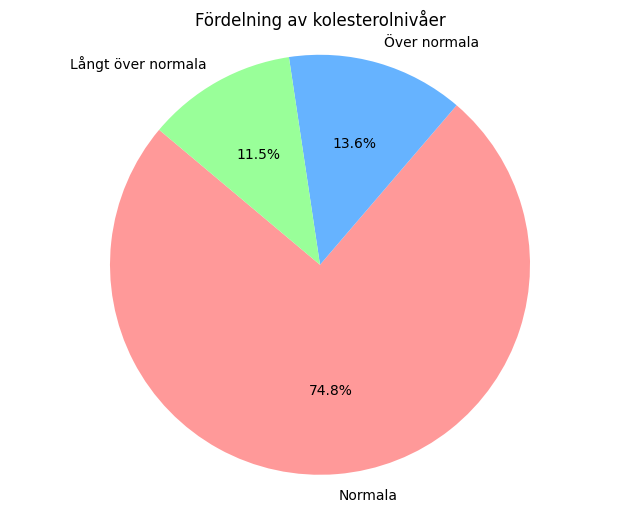

In [40]:
# Hur stor andel har normala, över normala och långt över normala kolesterolvärden?
normal_count = sum((df_cardio['cholesterol'] == 1))
over_normal_count = sum((df_cardio['cholesterol'] == 2))
far_over_normal_count = sum((df_cardio['cholesterol'] == 3))

# Beräknar totalt antal personer
total_count = len(df_cardio)

# Beräknar andelen för varje kategori
normal_percentage = normal_count / total_count * 100
over_normal_percentage = over_normal_count / total_count * 100
far_over_normal_percentage = far_over_normal_count / total_count * 100

labels = ['Normala', 'Över normala', 'Långt över normala']
sizes = [normal_percentage, over_normal_percentage, far_over_normal_percentage]
colors = ['#ff9999','#66b3ff','#99ff99']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Fördelning av kolesterolnivåer')
plt.axis('equal')
plt.show()

In [41]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'ageY'],
      dtype='object')

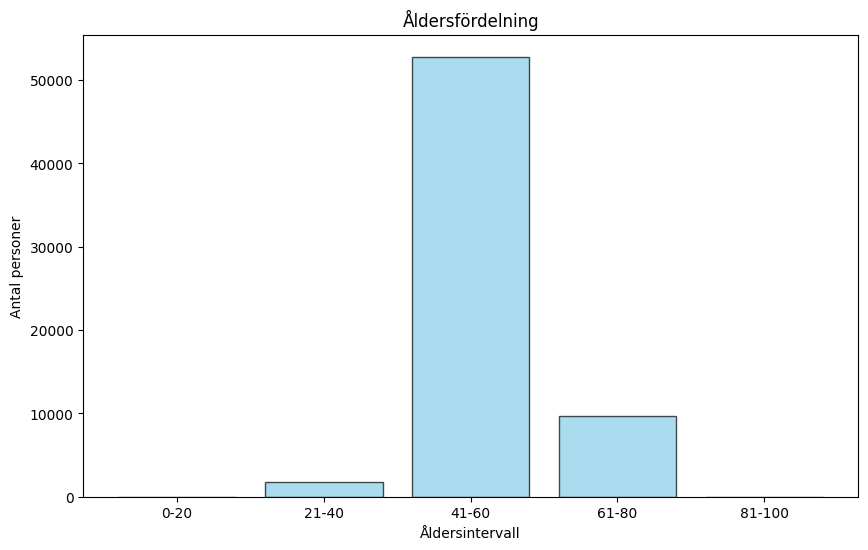

In [42]:
# Skapar anpassade åldersspann
age_intervals = [(0, 20), (21, 40), (41, 60), (61, 80), (81, 100)]

# Beräknar antalet personer i varje åldersspann
age_counts = [((df['ageY'] >= start) & (df['ageY'] <= end)).sum() for start, end in age_intervals]

# Stapeldiagram för åldersfördelning
plt.figure(figsize=(10, 6))
plt.bar(range(len(age_intervals)), age_counts, color='skyblue', edgecolor='black', alpha=0.7)

plt.xticks(range(len(age_intervals)), ['0-20', '21-40', '41-60', '61-80', '81-100'])
plt.xlabel('Åldersintervall')
plt.ylabel('Antal personer')
plt.title('Åldersfördelning')
plt.show()

In [43]:
non_smoker_count = sum(df_cardio['smoke'] == 0)

smoker_count = sum(df_cardio['smoke'] == 1)

print(f'Antal rökare: {smoker_count}')
print(f'Antal icke rökare: {non_smoker_count}')

num_smokers = df_cardio[df_cardio['smoke'] == 1]['smoke'].count()

# Beräknar totala antalet personer
total_persons = df_cardio.shape[0]

# Beräknar andelen rökare
smoking_percentage = (num_smokers / total_persons) * 100

print(f'Andelen rökare är: {smoking_percentage:.2f}%')

Antal rökare: 6169
Antal icke rökare: 63831
Andelen rökare är: 8.81%


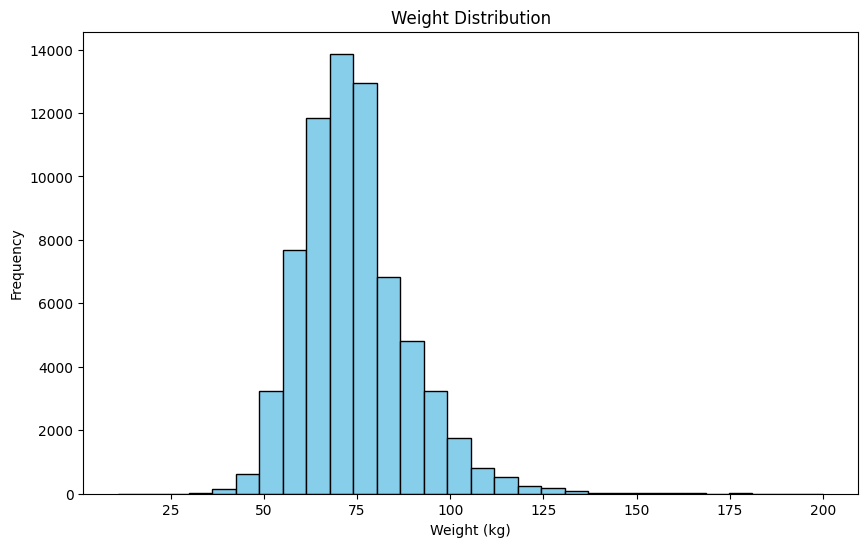

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(df['weight'], bins=30, color='skyblue', edgecolor='black')
plt.title('Weight Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()

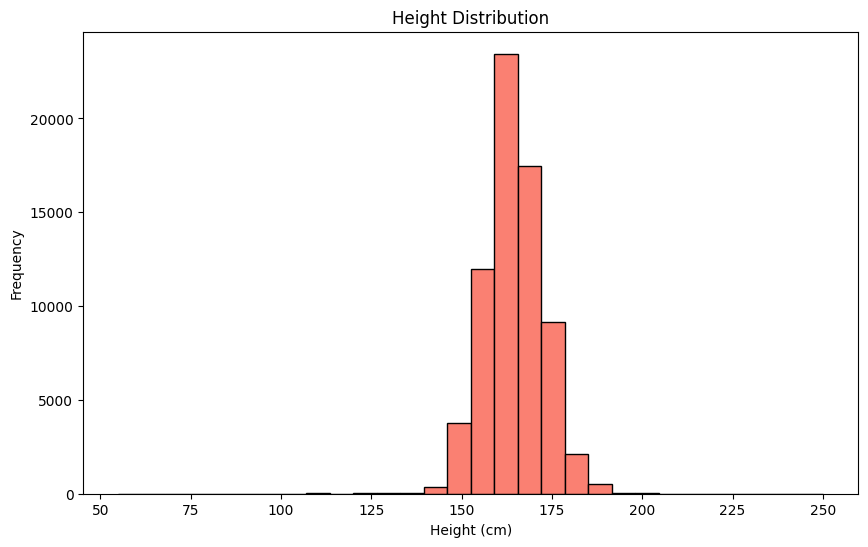

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(df['height'], bins=30, color='salmon', edgecolor='black')
plt.title('Height Distribution')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()

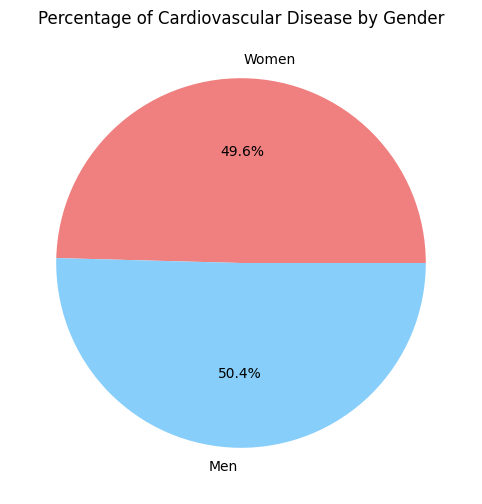

In [46]:
total_women = len(df_cardio[df_cardio['gender'] == 1])
total_men = len(df_cardio[df_cardio['gender'] == 2])

women_with_cardio = len(df_cardio[(df_cardio['gender'] == 1) & (df_cardio['cardio'] == 1)])
men_with_cardio = len(df_cardio[(df_cardio['gender'] == 2) & (df_cardio['cardio'] == 1)])

# Beräknar andelen för kvinnor och män
women_ratio = women_with_cardio / total_women
men_ratio = men_with_cardio / total_men

sizes = [women_ratio, men_ratio]
labels = ['Women', 'Men']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Percentage of Cardiovascular Disease by Gender')
plt.show()

# 2.1.0 - Feature engineering BMI

In [47]:
import seaborn as sns

In [70]:
# Delar in bmi i grupper för att reducera så stort spann av värden
#<16 = 0 (Severe Thinness)
#16-18.5 = 1 (Underweight)
#18.5-25 = 2 (Normal range)
#25-30 = 3 (Pre-obese)
#30-35 = 4 (Obese (Class I))
#35-40 = 5 (Obese (Class II))
#40< = 6 (Obese (Class III))

# Skapar en ny funktion som räknar BMI
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

# Kontrollerar hur många NaN-värden som finns i 'BMI' -kolumnen
print("Antal NaN-värden i 'BMI' -kolumnen:", df['bmi'].isnull().sum())

# Tar bort rader med NaN-värden
df.dropna(subset=['bmi'], inplace=True)

df.loc[(df['bmi'] < 16 ), 'BMI'] = 0
df.loc[(df['bmi'] >= 16 ) & (df['bmi'] < 18.5), 'BMI'] = 1
df.loc[(df['bmi'] >= 18.5 ) & (df['bmi'] < 25), 'BMI'] = 2
df.loc[(df['bmi'] >= 25 ) & (df['bmi'] < 30), 'BMI'] = 3
df.loc[(df['bmi'] >= 30 ) & (df['bmi'] < 35), 'BMI'] = 4
df.loc[(df['bmi'] >= 35 ) & (df['bmi'] < 40), 'BMI'] = 5
df.loc[(df['bmi'] >= 40 ), 'BMI'] = 6

Antal NaN-värden i 'BMI' -kolumnen: 0


In [71]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'BMI', 'bmi',
       'BMI_category'],
      dtype='object')

BMI_category
Normal               25554
Övervikt             24744
Fetma (klass I)      11993
Fetma (klass II)      4241
Fetma (klass III)     1824
Underviktig            585
Gravt underviktig       58
Name: count, dtype: int64


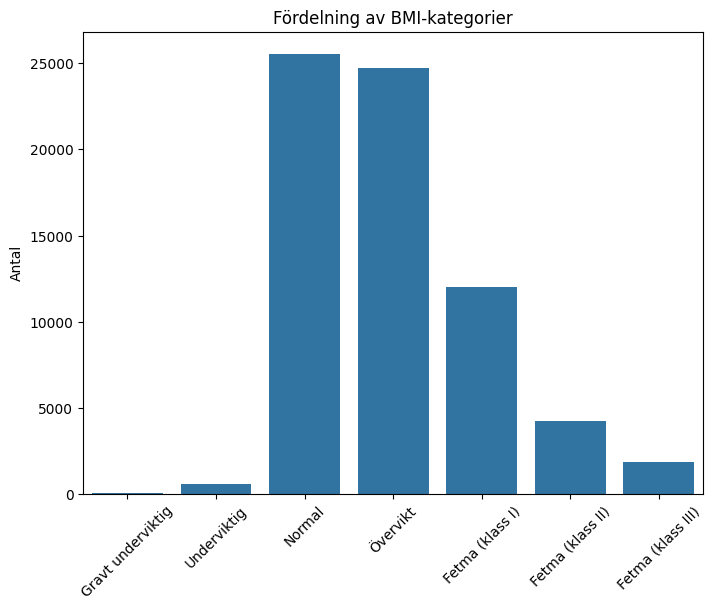

In [72]:
# Definierar BMI-kategorierna
bins = [0, 16, 18.5, 25, 30, 35, 40, float('inf')]
labels = ['Gravt underviktig', 'Underviktig', 'Normal', 'Övervikt', 'Fetma (klass I)', 'Fetma (klass II)', 'Fetma (klass III)']
df['BMI_category'] = pd.cut(df['BMI'], bins=bins, labels=labels, right=False)

# Lägger till 'BMI_category' baserat på 'BMI'
df['BMI_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

# Antalet observationer i varje kategori
print(df['BMI_category'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x='BMI_category', data=df, order=labels)
plt.title('Fördelning av BMI-kategorier')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('Antal')
plt.show()

# 2.1.1 - Feature engineering blodtryck

WHO:s riktlinjer för blodtryck:

- Normalt blodtryck: Systoliskt blodtryck < 120 mmHg och diastoliskt blodtryck < 80 mmHg
- Förhöjt blodtryck (prehypertoni): Systoliskt blodtryck 120-129 mmHg och/eller diastoliskt blodtryck < 80 mmHg
- Hypertoni steg 1: Systoliskt blodtryck 130-139 mmHg eller diastoliskt blodtryck 80-89 mmHg
- Hypertoni steg 2: Systoliskt blodtryck ≥ 140 mmHg eller diastoliskt blodtryck ≥ 90 mmHg

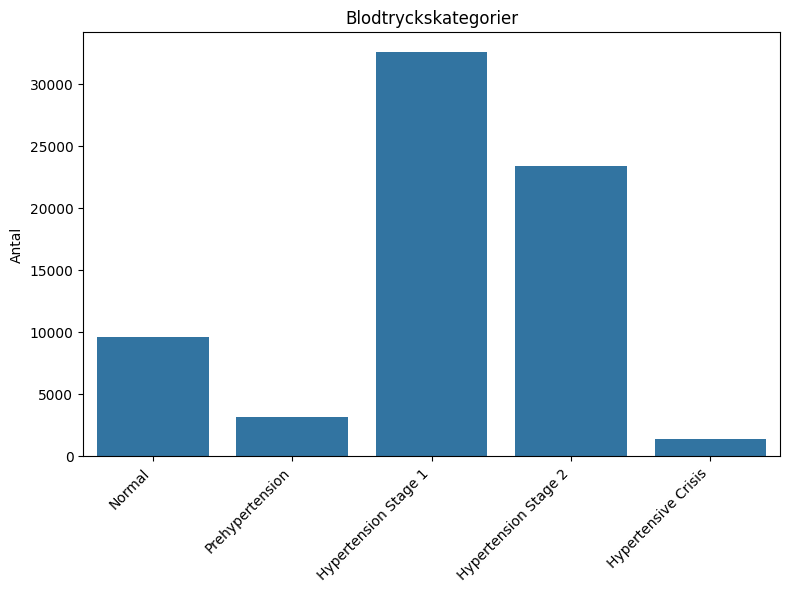

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Tagit hjälp av Chat GPT att rensa med kvantiler
df_cleaned_bp = df_cardio[['ap_hi', 'ap_lo', 'cardio']].copy()

# Hittar och ersätter värden som är utanför kvantilerna med NaN
# Rensar bort outliers och NaN-värden från 'ap_hi' och 'ap_lo'
quantile_025 = df_cleaned_bp['ap_hi'].quantile(0.025)
quantile_975 = df_cleaned_bp['ap_hi'].quantile(0.975)
df_cleaned_bp = df_cleaned_bp[(df_cleaned_bp['ap_hi'] >= quantile_025) & (df_cleaned_bp['ap_hi'] <= quantile_975)]

quantile_025 = df_cleaned_bp['ap_lo'].quantile(0.025)
quantile_975 = df_cleaned_bp['ap_lo'].quantile(0.975)
df_cleaned_bp = df_cleaned_bp[(df_cleaned_bp['ap_lo'] >= quantile_025) & (df_cleaned_bp['ap_lo'] <= quantile_975)]

# Skapar en ny feature "mmHG" för att gruppera blodtrycksvärdena
df_cardio.loc[(df_cardio['ap_hi'] < 120) & (df_cardio['ap_lo'] < 80), 'mmHG'] = 'Normal'
df_cardio.loc[((df_cardio['ap_hi'] >= 120) & (df_cardio['ap_hi'] <= 129)) & (df_cardio['ap_lo'] < 80), 'mmHG'] = 'Prehypertension'
df_cardio.loc[((df_cardio['ap_hi'] >= 130) & (df_cardio['ap_hi'] <= 139)) | ((df_cardio['ap_lo'] >= 80) & (df_cardio['ap_lo'] <= 89)), 'mmHG'] = 'Hypertension Stage 1'
df_cardio.loc[((df_cardio['ap_hi'] >= 140) & (df_cardio['ap_hi'] <= 180)) | ((df_cardio['ap_lo'] >= 90) & (df_cardio['ap_lo'] <= 120)), 'mmHG'] = 'Hypertension Stage 2'
df_cardio.loc[(df_cardio['ap_hi'] > 180) | (df_cardio['ap_lo'] > 120), 'mmHG'] = 'Hypertensive Crisis'

# Plottar blodtryckskategorierna
plt.figure(figsize=(8, 6))
sns.countplot(x='mmHG', data=df_cardio, order=['Normal', 'Prehypertension', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title('Blodtryckskategorier')
plt.ylabel('Antal')
plt.xlabel('')
plt.show()


# 2.2.0 - Visualisera andel sjukdomar

In [74]:
# Funktion för att definiera blodtryckskategorier
def blood_pressure_category(ap_hi, ap_lo):
    if ap_hi < 120 and ap_lo < 80:
        return 'Normal'
    elif 120 <= ap_hi <= 129 and ap_lo < 80:
        return 'Prehypertension'
    elif (130 <= ap_hi <= 139) or (80 <= ap_lo <= 89):
        return 'Hypertension Stage 1'
    elif (140 <= ap_hi <= 180) or (90 <= ap_lo <= 120):
        return 'Hypertension Stage 2'
    else:
        return 'Hypertensive Crisis'

# Skapar 'blood_pressure_category' baserat på 'ap_hi' och 'ap_lo'
df_cleaned_bp['blood_pressure_category'] = df_cleaned_bp.apply(lambda x: blood_pressure_category(x['ap_hi'], x['ap_lo']), axis=1)

# Nu har 'df_cleaned_bp' en ny kolumn 'blood_pressure_category' som innehåller blodtryckskategorierna


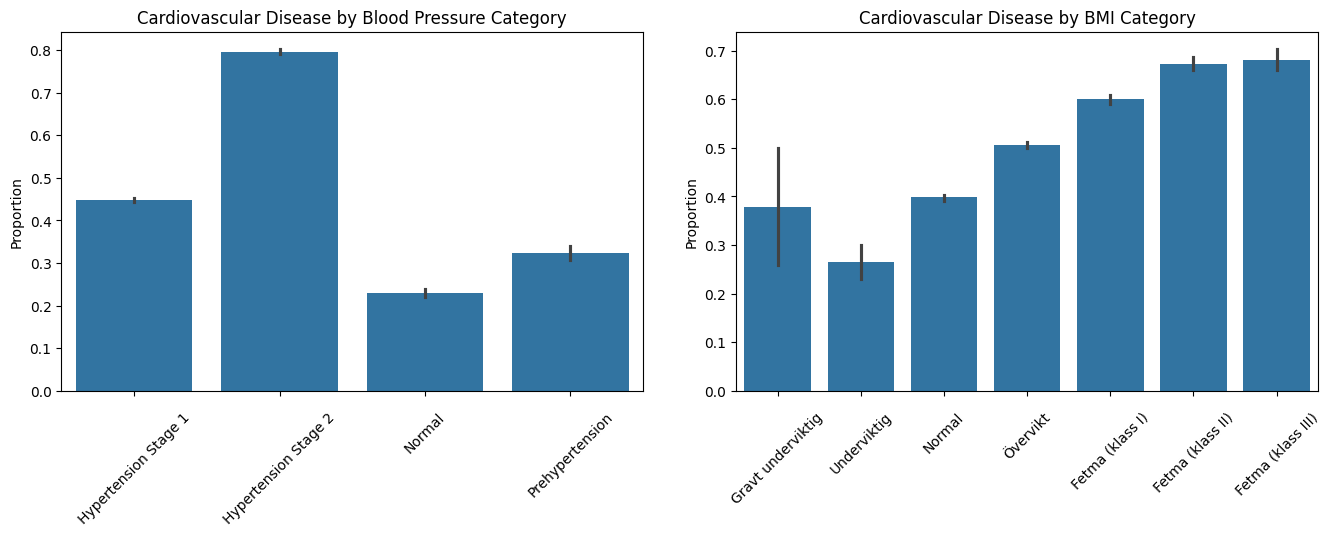

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Visar andel sjukdomar baserat på blodtryck
sns.barplot(x='blood_pressure_category', y='cardio', data=df_cleaned_bp, ax=axes[0])
axes[0].set_title('Cardiovascular Disease by Blood Pressure Category')
axes[0].set_xlabel('')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', rotation=45, pad=10)

# Visar andel sjukdomar baserat på BMI
sns.barplot(x='BMI_category', y='cardio', data=df, ax=axes[1])
axes[1].set_title('Cardiovascular Disease by BMI Category')
axes[1].set_xlabel('')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=45, pad=10)

plt.tight_layout(pad=3.0)

plt.show()


# 2.2.1 - Visualisera korrelation

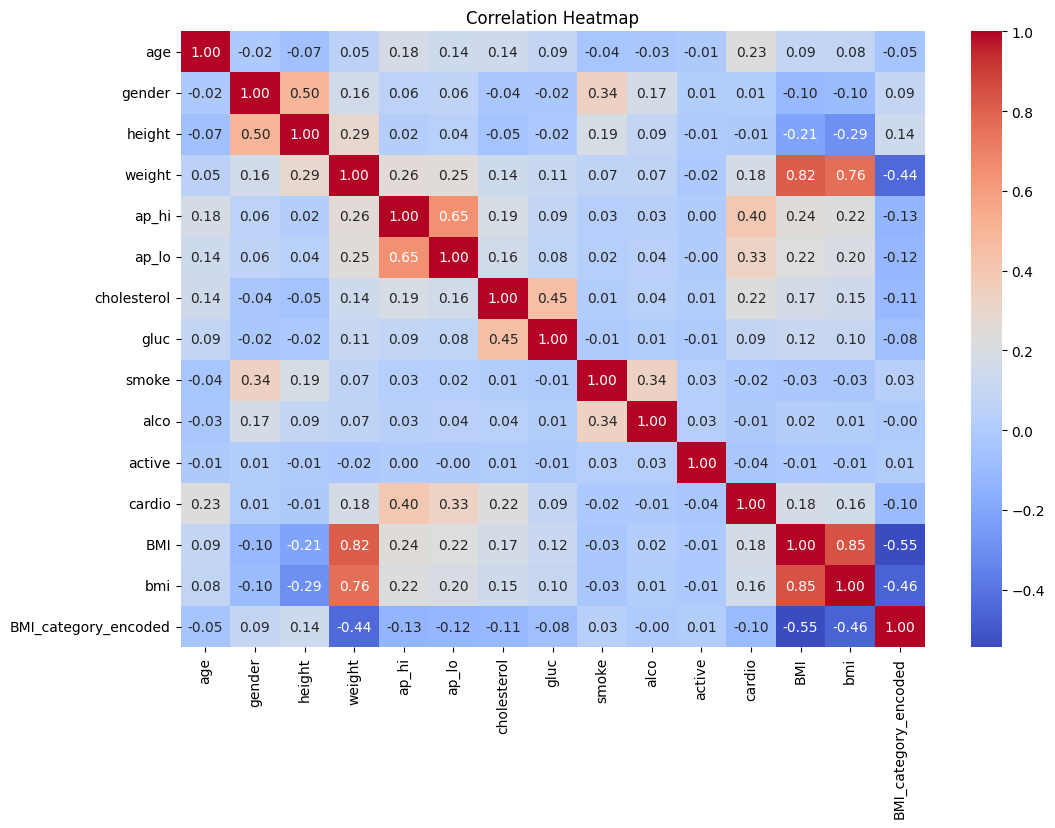

In [76]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Kodar om 'BMI_category' till numeriska värden
df['BMI_category_encoded'] = label_encoder.fit_transform(df['BMI_category'])

# Skapar korrelationsmatrisen efter att ha uteslutit icke-numeriska kolumner
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns=['BMI_category']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


# 2.2.2 - Ta bort korrelerade features

In [79]:
print(df.columns)

# Tar bort kolumnerna jag skapade tidigare (för att underlätta plot) från DataFrame för renare heatmap
df = df.drop(['bmi', 'BMI_category', 'BMI_category_encoded'], axis=1)

print(df.columns)

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'BMI', 'bmi',
       'BMI_category', 'BMI_category_encoded'],
      dtype='object')
Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'BMI'],
      dtype='object')


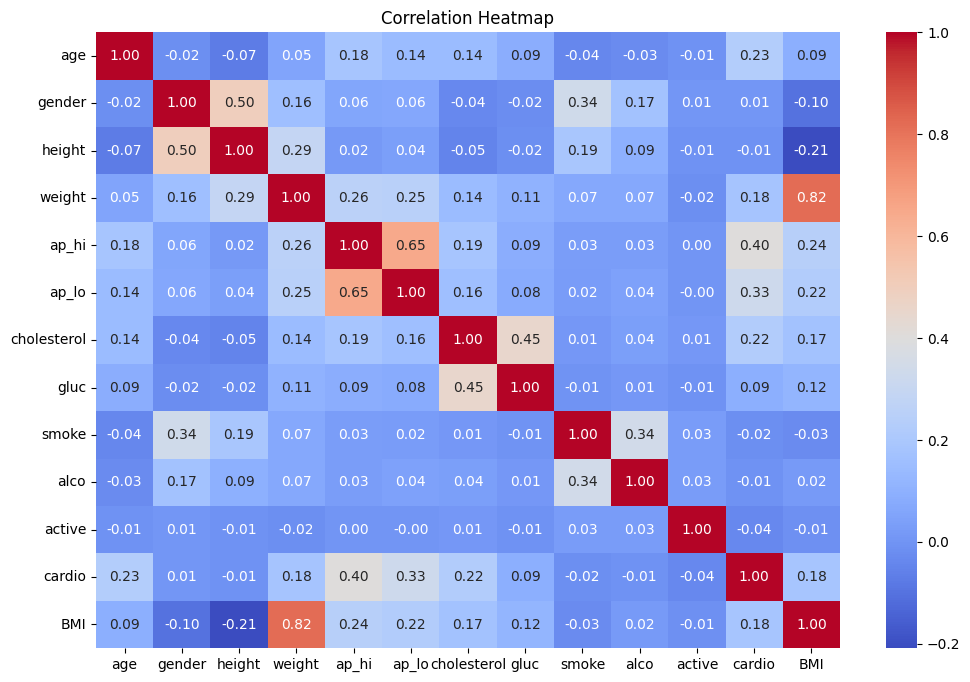

In [80]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 2.3 - Välja modell
Välj 3-5 maskininlärningsmodeller, gärna så olika som möjligt och gör följande:

- train|validation|test split
- skala datasetet med feature standardization eller normalization
- definiera hyperparametrar (param_grids) att testa för varje modell
- använda GridSearchCV() och välja lämplig evalueringsmetric
- gör prediction på valideringsdata

- beräkna och spara evaluation score för ditt valda metric
- checka bästa parametrarna för respektive modell

### https://www.youtube.com/watch?v=i_LwzRVP7bg&t=3738s&ab_channel=freeCodeCamp.org

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [60]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'BMI'],
      dtype='object')

In [61]:
# Train|Validation|Test Split
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [62]:
#Skalning av datasetet med feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Definierar hyperparametrarna (param_grids) för test av logistisk regression. !Testat [0.001, 0.01, 0.1, 1, 10, 100] 100 är bäst
param_grid = {'C': [100]}

# GridSearchCV() och lämplig evalueringsmetod
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Prediction på valideringsdatan
y_val_pred = grid_search.predict(X_val_scaled)

# Räknar och sparar evaluation score för accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Kollar av de bästa parametrarna för logistisk regression
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Klassifikations report för modellen av valideringsdata
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print('---------------------------------------------------')

# Skapar och tränar Random Forest-modellen
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Tar fram prediktioner på testdatan
y_pred = rf_model.predict(X_test)

# Räknar ut noggrannheten av modellen
accuracy = accuracy_score(y_test, y_pred)
print("Random forest accuracy:", accuracy)
print(classification_report(y_test, y_pred))

print('---------------------------------------------------')

# Skapar och tränar SVM-modellen
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train)

# Preduktar testuppsättningen
y_pred = svm_model.predict(X_test_scaled)

# Beräknar noggrannheten
accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy:", accuracy)
print(classification_report(y_test, y_pred))

print('---------------------------------------------------')

knn_model = KNeighborsClassifier(n_neighbors=20)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
print("KNN accuracy:", y_pred)
print(classification_report(y_test, y_pred))


Validation Accuracy: 0.7235748792270531
Best Parameters: {'C': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5261
           1       0.74      0.67      0.70      5089

    accuracy                           0.72     10350
   macro avg       0.73      0.72      0.72     10350
weighted avg       0.73      0.72      0.72     10350

---------------------------------------------------
Random forest accuracy: 0.6933333333333334
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      5210
           1       0.70      0.68      0.69      5140

    accuracy                           0.69     10350
   macro avg       0.69      0.69      0.69     10350
weighted avg       0.69      0.69      0.69     10350

---------------------------------------------------
SVM accuracy: 0.7286956521739131
              precision    recall  f1-score   support

           0       0

# 2.4

In [63]:
from sklearn.ensemble import VotingClassifier

# Skapar en VotingClassifier med min tidigare SVM-modell
voting_clf = VotingClassifier(estimators=[('svm', svm_model)], voting='hard')

voting_param_grid = {
    'voting': ['hard', 'soft']
}

# Skapa en GridSearchCV för VotingClassifier och specificera parametrarna
grid_search = GridSearchCV(estimator=voting_clf, param_grid=voting_param_grid, cv=5)

# Träna GridSearchCV-objektet
grid_search.fit(X_train, y_train)

# Hämta de bästa parametrarna
best_params = grid_search.best_params_

print("Best parameters for VotingClassifier:", best_params)


Best parameters for VotingClassifier: {'voting': 'soft'}


# 2.5

In [64]:
# Gör förutsägelser med ensemble-modellen på valideringsdata
y_pred_val = grid_search.predict(X_val_scaled)

# Skapa förvirringsmatrisen
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

# Skapa klassificeringsrapportet
class_report = classification_report(y_val, y_pred_val)
print("Classification Report:")
print(class_report)


c:\Users\Sandra\Documents\Visual_Studio_Code\Github\AI-Sandra-Andersson-OPA23\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Confusion Matrix:
[[   0 5261]
 [   0 5089]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5261
           1       0.49      1.00      0.66      5089

    accuracy                           0.49     10350
   macro avg       0.25      0.50      0.33     10350
weighted avg       0.24      0.49      0.32     10350



c:\Users\Sandra\Documents\Visual_Studio_Code\Github\AI-Sandra-Andersson-OPA23\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sandra\Documents\Visual_Studio_Code\Github\AI-Sandra-Andersson-OPA23\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Sandra\Documents\Visual_Studio_Code\Github\AI-Sandra-Andersson-OPA23\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

## 2.6

In [83]:
import joblib
from sklearn.utils import shuffle

# 100 slumpmässiga rader
test_samples = df.sample(n=100, random_state=42)

# Exporterar testdatan till en CSV-fil
test_samples.to_csv('data/test_samples.csv', index=False)

# Ta bort testdatan från datasetet
df = df.drop(test_samples.index)

# Delar upp i tränings- och testdelar
X = df.drop('cardio', axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skapar och tränar SVM-modellen på hela datasetet förutom test_samples
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

# Sparar modellen som en .pkl-fil
joblib.dump(svm_model, 'data/svm_model.pkl', compress=True)


['svm_model.pkl']